# Multiple Particle Tracking
-----------------
This code is obtained from DeepTrack2 library notebooks: https://github.com/softmatterlab/DeepTrack2

**Adapted by:** Juan C. Peña and Eberto Benjumea

In [6]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
!pip install deeptrack

In [2]:
import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2

# SETUP

In [127]:
n = 10 # Number of train image
m = 3 # Number of test image

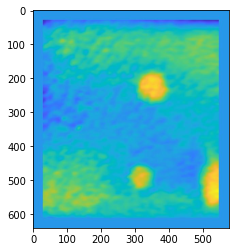

In [128]:
# Preprocessing

#image = dt.LoadImage(f'../input/wheals-data/Data/jpg/train/images/{n}.jpg')()._value / 256
path = f'/content/drive/MyDrive/Investigacion/Data/jpg/train/images/{n}.jpg'
image = dt.LoadImage(path)()._value / 256

# plt.imshow(image)
plt.imshow(image, cmap='gray')

(96, 87)


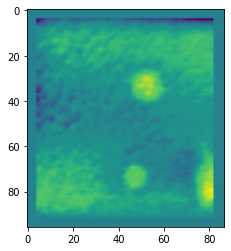

In [129]:
gray_image = 0.21*image[:,:,0] + 0.72*image[:,:,1] + 0.07*image[:,:,2] # Convert to grayscale manually

# Resizing
resized_image = cv2.resize(gray_image, (0, 0), fx=0.15, fy=0.15)
plt.imshow(resized_image)
print(resized_image.shape)
#plt.axis("off")

(40, 40)
(40, 40, 1)


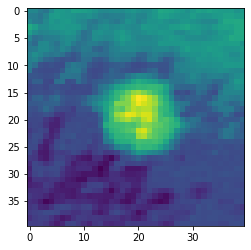

In [135]:
# Cropping
# t, x, y, w = (251, 28, 26, 40) # n = 2
t, x, y, w = (251, 32, 14, 40) # n = 10

crop = resized_image[y:y+w, x:x+w]
print(crop.shape)
plt.imshow(crop)
training_image = np.expand_dims(crop, axis = 2) # Add a third channel
print(training_image.shape)
#plt.axis("off")

In [136]:
from deeptrack.models.lodestar.generators import LodeSTARGenerator
from deeptrack.augmentations import Affine
from deeptrack.features import Value

from deeptrack.models.lodestar.equivariances import (
    ScaleEquivariance,
    TranslationalEquivariance,
    Rotational2DEquivariance,
)

In [137]:
# Transformations
a = Affine(translate = lambda: [np.random.randn() * 2] * 2)
b = Affine(rotate = lambda: np.random.rand() * 2 * np.pi * 2)
c = Affine(scale = lambda: [np.random.uniform(low=0.7, high=2)] * 2)

In [138]:
# Define default transformations
DEFAULT_TRANSFORMATION_FUNCTION2 = c >> b >> a

# Define default equivariances
DEFAULT_EQUIVARIANCE2 = ScaleEquivariance(c.scale) >> Rotational2DEquivariance(b.rotate) >> TranslationalEquivariance(a.translate)

In [139]:
class LodeSTARGeneratorUTB(LodeSTARGenerator):
    """Data generator for use with an LodeSTARer.

    Parameters
    ----------
    feature : Feature
        DeepTrack feature returning crops of single objects.
    num_outputs : int
        Number of values the model is expected to predict (not including the weight-map)
    transformation_function : Feature, Feature, optional
        Tuple of features defining transformations applied to each crop as well as the corresponding equivariance.


    """

    def __init__(
        self,
        feature,
        num_outputs=2,
        transformation_function=(DEFAULT_TRANSFORMATION_FUNCTION2, DEFAULT_EQUIVARIANCE2),
        **kwargs
    ):

        transformation_input = Value(
            lambda: (np.eye(num_outputs), np.zeros((num_outputs, 1)))
        )

        self.transformation_function = transformation_function[0] & (
            transformation_input >> transformation_function[1]
        )
        self.num_outputs = num_outputs
        super().__init__(feature, **kwargs)

In [140]:
train_set =   (
    dt.Value(training_image)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

In [141]:
generatorUTB = LodeSTARGeneratorUTB

In [142]:
model = dt.models.LodeSTAR(input_shape=(None, None, 1))

In [143]:
model.data_generator = generatorUTB

In [144]:
model.fit(
    train_set,
    epochs=40,
    batch_size=8,
)

# Saving weights
model.save_weights('./model.h5')

Generating 165 / 160 samples before starting training
Epoch 1/40
165/165 [==============================] - 6s 13ms/step - total_loss: 3.0352 - consistency_loss: 1.5097
Epoch 2/40
165/165 [==============================] - 2s 13ms/step - total_loss: 2.9500 - consistency_loss: 1.4228
Epoch 3/40
165/165 [==============================] - 2s 14ms/step - total_loss: 3.1876 - consistency_loss: 1.1496
Epoch 4/40
165/165 [==============================] - 2s 14ms/step - total_loss: 1.3306 - consistency_loss: 0.4954
Epoch 5/40
165/165 [==============================] - 2s 14ms/step - total_loss: 0.7525 - consistency_loss: 0.2997
Epoch 6/40
165/165 [==============================] - 2s 15ms/step - total_loss: 0.5250 - consistency_loss: 0.2145
Epoch 7/40
165/165 [==============================] - 2s 14ms/step - total_loss: 0.3799 - consistency_loss: 0.1551
Epoch 8/40
165/165 [==============================] - 2s 14ms/step - total_loss: 0.3064 - consistency_loss: 0.1170
Epoch 9/40
165/165 [======

1/1 [==============================] - 0s 31ms/step


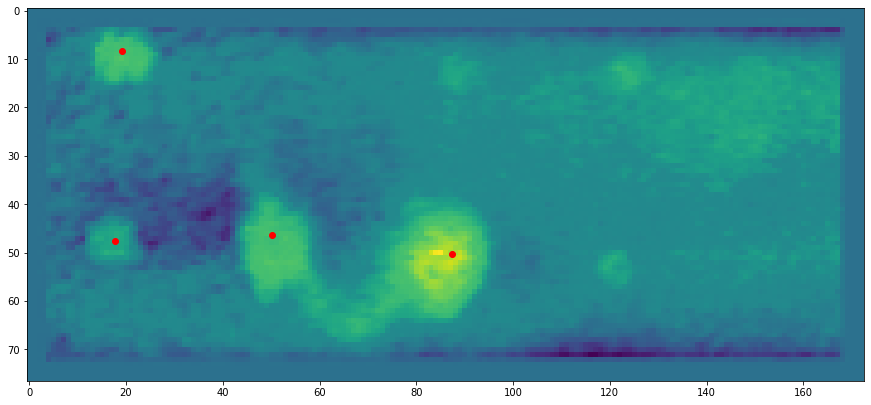

In [168]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/jpg/train/images/{3}.jpg'
image2 = dt.LoadImage(path2)()._value / 256
gray_image2 = 0.21*image2[:,:,0] + 0.72*image2[:,:,1] + 0.07*image2[:,:,2] # Convert to grayscale manually
resized_image2 = cv2.resize(gray_image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
# detections = autotracker.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant")

plt.figure(figsize=(15, 15))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")

In [ ]:
# Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)